In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm_notebook

from fastai.conv_learner import ConvLearner
from fastai.dataset import ImageClassifierData, get_cv_idxs
from fastai.transforms import tfms_from_model

In [2]:
%matplotlib inline

# Lesson 4 - Adding Dropout to spreadsheet CNN

In [3]:
PATH = Path('./data/mnist')
PATH.mkdir(exist_ok=True)

## Dataset

```
kaggle competitions download -c digit-recognizer --path={PATH}
```

In [4]:
df = pd.read_csv(PATH/'train.csv')

### Load a single image

In [5]:
img_pixels = df.loc[7, [c for c in df.columns if c.startswith('pixel')]]
img_arr = np.array([int(i) for i in img_pixels])
img_arr = img_arr.reshape((28, 28))
img_arr_float = img_arr / 255.

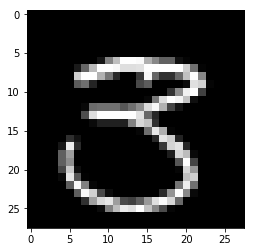

In [6]:
plt.imshow(img_arr_float, cmap='gray')
plt.show()

In [7]:
img_arr_float = img_arr_float.reshape(1, 28, 28)
img_tensor = torch.from_numpy(img_arr_float)
img_tensor = img_tensor.unsqueeze(0).cpu().float()

### Exploring new model

I'll start by improving the model by adding 2 things:
  1. Much more output channels in CNN, from 2 to 32 in the first layer and 2 to 64 in the second layer.
  2. An extra fully-connected layer on the end.

Let's make sure the outputs are as we expect:

In [8]:
conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

In [9]:
output = conv1(Variable(img_tensor))

In [10]:
output.shape

torch.Size([1, 32, 28, 28])

Note how I've added 1 pixel of padding on both sides of the output.

This means that the conv will return the same size image output, which is slightly easier to deal with. We then know that the Maxpool will return the size by half:

In [11]:
output = F.max_pool2d(output, 2)

In [12]:
output.shape

torch.Size([1, 32, 14, 14])

### Dropout in action

We are also adding Dropout. Let's explore what Dropout with 100% probability will look like.

First, let's see the output image:

In [13]:
output[0]

Variable containing:
(0 ,.,.) = 
  1.3262e-01  1.3262e-01  1.3262e-01  ...   1.3262e-01  1.3262e-01  1.3262e-01
  1.3262e-01  1.3262e-01  1.3262e-01  ...   1.3262e-01  1.3262e-01  1.3262e-01
  1.3262e-01  1.3262e-01  1.3262e-01  ...   1.3262e-01  1.3262e-01  1.3262e-01
                 ...                   ⋱                   ...                
  1.3262e-01  1.3262e-01  1.7289e-02  ...   1.3262e-01  1.3262e-01  1.3262e-01
  1.3262e-01  1.3262e-01  1.3262e-01  ...   1.3262e-01  1.3262e-01  1.3262e-01
  1.3262e-01  1.3262e-01  1.3262e-01  ...   1.3262e-01  1.3262e-01  1.3262e-01

(1 ,.,.) = 
 -6.8213e-02 -6.8213e-02 -6.8213e-02  ...  -6.8213e-02 -6.8213e-02 -6.8213e-02
 -6.8213e-02 -6.8213e-02 -6.8213e-02  ...  -6.8213e-02 -6.8213e-02 -6.8213e-02
 -6.8213e-02 -6.8213e-02 -6.8213e-02  ...  -6.8213e-02 -6.8213e-02 -6.8213e-02
                 ...                   ⋱                   ...                
 -6.8213e-02 -6.6136e-02 -3.4751e-02  ...   9.1516e-02 -6.8213e-02 -6.8213e-02
 -6.82

Let's now create Dropout with 100% prob:

In [14]:
dropout = nn.Dropout(p=1)

In [15]:
dropout_output = dropout(output)

In [16]:
dropout_output[0]

Variable containing:
(0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

(1 ,.,.) = 
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
     ...       ⋱       ...    
  -0  -0  -0  ...    0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0

(2 ,.,.) = 
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
     ...       ⋱       ...    
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
...

(29,.,.) = 
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
     ...       ⋱       ...    
  -0  -0   0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0
  -0  -0  -0  ...   -0  -0  -0

(30,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0

Notice how all the activations are 0? What about 0.5?

In [17]:
dropout = nn.Dropout(p=0.5)
dropout_output = dropout(output)

In [18]:
dropout_output[0]

Variable containing:
(0 ,.,.) = 
  0.0000  0.2652  0.0000  ...   0.2652  0.2652  0.0000
  0.0000  0.0000  0.2652  ...   0.2652  0.2652  0.0000
  0.0000  0.2652  0.2652  ...   0.0000  0.0000  0.0000
           ...             ⋱             ...          
  0.0000  0.2652  0.0346  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.2652
  0.2652  0.0000  0.0000  ...   0.2652  0.2652  0.0000

(1 ,.,.) = 
 -0.0000 -0.0000 -0.1364  ...  -0.0000 -0.1364 -0.1364
 -0.1364 -0.1364 -0.0000  ...  -0.1364 -0.1364 -0.0000
 -0.0000 -0.1364 -0.1364  ...  -0.1364 -0.1364 -0.1364
           ...             ⋱             ...          
 -0.1364 -0.0000 -0.0000  ...   0.1830 -0.1364 -0.1364
 -0.1364 -0.0000 -0.0974  ...  -0.1173 -0.1364 -0.0000
 -0.1364 -0.1364 -0.1364  ...  -0.1364 -0.1364 -0.0000

(2 ,.,.) = 
 -0.0000 -0.4873 -0.4873  ...  -0.4873 -0.4873 -0.0000
 -0.0000 -0.0000 -0.0000  ...  -0.0000 -0.0000 -0.0000
 -0.0000 -0.4873 -0.4873  ...  -0.0000 -0.0000 -0.4873
      

Now, 50% of the activations are dropped out.

## Build model

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, p=0.5):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
       
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.maxpool_conv2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2_dropout = nn.Dropout(p=p)

        self.fc1 = nn.Linear(in_features=64 * 14 * 14, out_features=1024)
        self.fc1_dropout = nn.Dropout(p=p)
        self.fc2 = nn.Linear(in_features=1024, out_features=10)
        self.softmax_output = nn.LogSoftmax(dim=1)
        
    def forward(self, img_batch):
        conv1_output = self.conv1(img_batch)
        conv1_relu_output = F.relu(conv1_output)
        
        conv2_output = self.conv2(conv1_relu_output)
        relu2_output = F.relu(conv2_output)

        maxpool_conv2_output = self.maxpool_conv2(relu2_output)
        dropout_conv2_output = self.conv2_dropout(maxpool_conv2_output)
        
        flattened_output = dropout_conv2_output.view(img_batch.size(0), -1)
        
        fc1_output = self.fc1(flattened_output)
        fc1_relu_output = F.relu(fc1_output)
        
        fc1_dropout_output = self.fc1_dropout(fc1_relu_output)
        fc2_output = self.fc2(fc1_dropout_output)
        softmax_output = self.softmax_output(fc2_output)
        return softmax_output

## Train

### Without dropout

I can then create a ImageClassifierData object as usual, use the `from_model_data` constructor to create a `ConvLearner` from my custom model.

Note: the `train_prepared.csv` file is created in [lesson3-spreadsheet-cnn.ipynb] notebook.

In [20]:
train_df = pd.read_csv(PATH/'train_prepared.csv')

In [21]:
val_idx = get_cv_idxs(len(train_df))

Let's start with a CNN that drops activations with a probability of 0% (ie no Dropout).

In [22]:
cnn = SimpleCNN(in_channels=3, p=0)

In [23]:
cnn

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_conv2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2_dropout): Dropout(p=0)
  (fc1): Linear(in_features=12544, out_features=1024, bias=True)
  (fc1_dropout): Dropout(p=0)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (softmax_output): LogSoftmax()
)

In [24]:
data = ImageClassifierData.from_csv(
    PATH, 'train', PATH/'train_prepared.csv', tfms=tfms_from_model(cnn, 28), val_idxs=val_idx, suffix='.jpg')

In [25]:
conv_learner = ConvLearner.from_model_data(cnn, data)

In [26]:
conv_learner.lr_find()

 71%|███████▏  | 375/525 [00:03<00:01, 95.46it/s, loss=0.406]


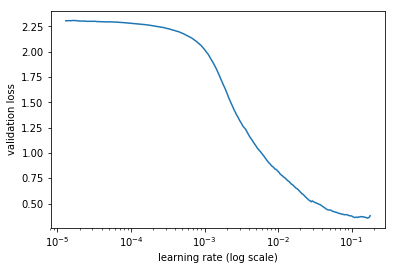

In [27]:
conv_learner.sched.plot()

* Note that cycle_mult refers to the amount we multiple the cycle each epoch.
  * With `cycle_len=1` we multiple the 2nd batch by 2, then the 3rd by 4 and 4th by 8.
    * cycle 1: cycle_len = 1
    * cycle 2: cycle_len = 1 * 2  # 2
    * cycle 3: cycle_len = 2 * 2  # 4
    * cycle 4: cycle_len = 4 * 2  # 8
    * cycle 5: cycle_len = 8 * 2  # 16 
    * total cycles = 1 + 2 + 4 + 8 + 16 = 31

In [28]:
conv_learner.fit(0.01, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.071611   0.072062   0.97869   
    1      0.046099   0.049345   0.984405                      
    2      0.021095   0.038125   0.988929                      
    3      0.033859   0.040211   0.987262                      
    4      0.013272   0.037701   0.989167                      
    5      0.006975   0.033728   0.99                           
    6      0.002763   0.032949   0.990357                       
    7      0.017982   0.04124    0.987976                       
    8      0.0129     0.03689    0.990952                       
    9      0.003133   0.036863   0.990357                       
    10     0.001767   0.035983   0.99131                         
    11     0.000586   0.03552    0.991667                        
    12     0.000436   0.036014   0.991548                        
    13     0.000431   0.036234   0.991548                        
    14     0.000373   0.036236   0.991548      

[array([0.04049]), 0.9921428571428571]

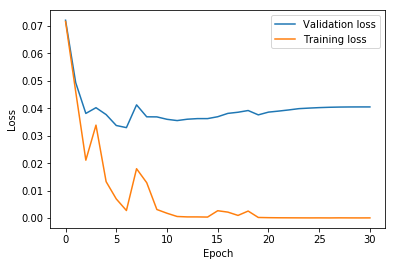

In [29]:
epoch_num = list(range(conv_learner.sched.epoch))
plt.plot(epoch_num, conv_learner.sched.val_losses, label='Validation loss')
plt.plot(
    epoch_num,
    [conv_learner.sched.losses[i-1] for i in conv_learner.sched.epochs],
    label='Training loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### With Dropout

Let's add a bit of dropout. Set it initially to 0.5 and see if we can train a bit longer before we start to overfit.

In [30]:
cnn = SimpleCNN(in_channels=3, p=0.5)

In [31]:
cnn

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_conv2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2_dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=12544, out_features=1024, bias=True)
  (fc1_dropout): Dropout(p=0.5)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (softmax_output): LogSoftmax()
)

In [32]:
conv_learner = ConvLearner.from_model_data(cnn, data)

In [33]:
conv_learner.lr_find()

 73%|███████▎  | 385/525 [00:03<00:01, 97.20it/s, loss=1.48] 


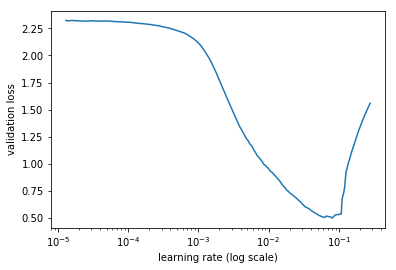

In [34]:
conv_learner.sched.plot()

In [35]:
conv_learner.fit(0.01, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.113108   0.08288    0.974167  
    1      0.08609    0.052456   0.984167                     
    2      0.050787   0.041255   0.987262                     
    3      0.065456   0.045727   0.985476                     
    4      0.048877   0.033467   0.989048                     
    5      0.033101   0.030289   0.990952                     
    6      0.0256     0.029639   0.990952                     
    7      0.042441   0.033894   0.989881                     
    8      0.038074   0.034747   0.989167                     
    9      0.031708   0.039114   0.988571                     
    10     0.023437   0.02885    0.99                         
    11     0.017076   0.028178   0.99131                      
    12     0.015583   0.026814   0.992619                     
    13     0.008819   0.026448   0.992976                      
    14     0.01094    0.026296   0.993095                      
    15    

[array([0.02428]), 0.9940476190476191]

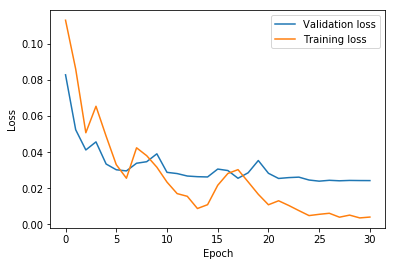

In [36]:
epoch_num = list(range(conv_learner.sched.epoch))
plt.plot(epoch_num, conv_learner.sched.val_losses, label='Validation loss')
plt.plot(
    epoch_num,
    [conv_learner.sched.losses[i-1] for i in conv_learner.sched.epochs],
    label='Training loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### With augmentations

In [37]:
from fastai.transforms import RandomRotate, RandomLighting

In [38]:
augs = [RandomRotate(10), RandomLighting(0.05, 0.05)]
transforms = tfms_from_model(cnn, 28, aug_tfms=augs)
data = ImageClassifierData.from_csv(
    PATH, 'train', PATH/'train_prepared.csv', tfms=transforms, val_idxs=val_idx, suffix='.jpg')

In [39]:
cnn = SimpleCNN(in_channels=3, p=0.5)

In [40]:
conv_learner = ConvLearner.from_model_data(cnn, data)

In [41]:
conv_learner.fit(0.01, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.12581    0.082005   0.974524  
    1      0.081415   0.055441   0.983214                     
    2      0.061585   0.040126   0.987619                     
    3      0.075954   0.042168   0.987143                     
    4      0.054066   0.032278   0.989167                     
    5      0.035698   0.028315   0.990238                     
    6      0.028319   0.027239   0.990952                     
    7      0.055059   0.033121   0.98881                      
    8      0.051193   0.032129   0.989643                     
    9      0.03148    0.03251    0.989643                     
    10     0.027667   0.024752   0.992619                     
    11     0.021723   0.023834   0.992619                     
    12     0.019213   0.023622   0.993452                     
    13     0.015231   0.023294   0.993214                     
    14     0.016722   0.023305   0.993095                     
    15     0

[array([0.02332]), 0.9939285714285714]

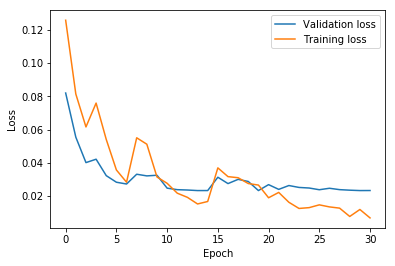

In [47]:
epoch_num = list(range(conv_learner.sched.epoch))
plt.plot(epoch_num, conv_learner.sched.val_losses, label='Validation loss')
plt.plot(
    epoch_num,
    [conv_learner.sched.losses[i-1] for i in conv_learner.sched.epochs],
    label='Training loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [43]:
val_preds, y = conv_learner.TTA()

In [44]:
val_preds_mean = np.mean(val_preds, axis=0)

In [45]:
np.mean(np.argmax(val_preds_mean, axis=1) == y)

0.9939285714285714